<p align="center"><img src="https://i0.wp.com/mkengland.com/wp-content/uploads/2020/09/goodreads-logo.png?ssl=1" alt="pic" width="600" height="400" /> </p>

In [1]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import nan_euclidean_distances
import warnings
import re

%matplotlib inline
warnings.filterwarnings("ignore")

The dataset is sourced from kaggle (https://www.kaggle.com/datasets/zygmunt/goodbooks-10k) where the metadata has been extracted from Amazon's Goodreads website

**to_read.csv** provides IDs of the books marked "to read" by each user, as user_id,book_id pairs.

**books.csv** has metadata for each book (goodreads IDs, authors, title, average rating, etc.).

**book_tags.csv** contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs.

**tags.csv** translates tag IDs to names.

In [2]:
#We read the data for each given dataset in our Google Drive.
#Then we checked the shape of our data

books_url = "https://drive.google.com/file/d/1gxjM1WmBPiTPU3NQfkfDYyzKxpTypC2U/view?usp=sharing"
books_file_id = books_url.split("/")[-2]
books_dwn_url = "https://drive.google.com/uc?id=" + books_file_id
books_main = pd.read_csv(books_dwn_url)

tags_url = "https://drive.google.com/file/d/1ekhdXG_f8Vvxjyca2KhQNRYSNiJIRvrr/view?usp=sharing"
tags_file_id = tags_url.split("/")[-2]
tags_dwn_url = "https://drive.google.com/uc?id=" + tags_file_id
tags = pd.read_csv(tags_dwn_url)

book_tags_url = "https://drive.google.com/file/d/1sW99qVNEHxW_pWGVQ1nkhA_G3M5gK0pB/view?usp=sharing"
book_tags_id = book_tags_url.split("/")[-2]
book_tags_url = "https://drive.google.com/uc?id=" + book_tags_id
book_tags = pd.read_csv(book_tags_url)

ratings_url = "https://drive.google.com/file/d/1HubJ93WezWUa4T33JOUC1yUgS0xKX2X4/view?usp=sharing"
ratings_id = ratings_url.split("/")[-2]
ratings_dwn_url = "https://drive.google.com/uc?id=" + ratings_id
ratings = pd.read_csv(ratings_dwn_url)

to_read_url = "https://drive.google.com/file/d/1uyioHOKM6auDx8mD6hx6Psc3lecF2LlR/view?usp=sharing"
to_read_id = to_read_url.split("/")[-2]
to_read_dwn_url = "https://drive.google.com/uc?id=" + to_read_id
to_read = pd.read_csv(to_read_dwn_url)

print("The shape of the Books.csv file =", books_main.shape)
print("The shape of the tags.csv file =", tags.shape)
print("The shape of the book_tags.csv file =", book_tags.shape)
print("The shape of the ratings.csv file =", ratings.shape)
print("The shape of the to_read.csv file =", to_read.shape)

#Set the max display for both columns and rows (optional to use)
#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

The shape of the Books.csv file = (10000, 23)
The shape of the tags.csv file = (34252, 2)
The shape of the book_tags.csv file = (999912, 3)
The shape of the ratings.csv file = (981756, 3)
The shape of the to_read.csv file = (912705, 2)


**Preprocessing steps**

---

We removed outliers such as:
- NaN values, 
- check for duplicates, 
- check if authors have books in other languages

In [3]:
books_main.language_code.value_counts()

eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
per         7
jpn         7
por         6
pol         6
en          4
nor         3
dan         3
fil         2
ita         2
vie         1
tur         1
nl          1
swe         1
rum         1
mul         1
rus         1
Name: language_code, dtype: int64

We checked to determine if there are any duplicate entries in the dataset - confirmed they are not

In [4]:
books_main.drop_duplicates(inplace = True)
books_main

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


We checked to determine if all books in our dataset are the best books on the Goodreads website - and we discovered some entries are not

Then we checked online to determine if the best book always includes an ISBN - some do, some do not

In [5]:
b = books_main[books_main["book_id"] != books_main["best_book_id"]]
b

#For example, we checked these two books on the Goodreads website
#books_main[books_main["original_title"] == "Gone Girl"]
#books_main[books_main["original_title"] == "Open Road Summer"]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
29,30,8442457,19288043,13306276,196,297859382,9.780298e+12,Gillian Flynn,2012.0,Gone Girl,...,512475,1626519,121614,38874,80807,280331,616031,610476,https://images.gr-assets.com/books/1339602131m...,https://images.gr-assets.com/books/1339602131s...
32,33,930,929,1558965,220,739326228,9.780739e+12,Arthur Golden,1997.0,Memoirs of a Geisha,...,1300209,1418172,25605,23500,59033,258700,517157,559782,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
37,38,14050,18619684,2153746,167,965818675,9.780966e+12,Audrey Niffenegger,2003.0,The Time Traveler's Wife,...,746287,1308667,43382,44339,85429,257805,427210,493884,https://images.gr-assets.com/books/1437728815m...,https://images.gr-assets.com/books/1437728815s...
53,54,11,386162,3078186,257,345391802,9.780345e+12,Douglas Adams,1979.0,The Hitchhiker's Guide to the Galaxy,...,936782,1006479,20345,21764,41962,145173,299579,498001,https://images.gr-assets.com/books/1327656754m...,https://images.gr-assets.com/books/1327656754s...
83,84,7677,6424171,3376836,176,030734813X,9.780307e+12,Michael Crichton,1990.0,Jurassic Park,...,447833,650483,8143,15736,34222,138327,231583,230615,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9776,9777,8428984,8428985,13292213,10,NaN,NaN,Hugh Howey,2010.0,NaN,...,5012,10231,787,161,799,3139,3942,2190,https://images.gr-assets.com/books/1374845830m...,https://images.gr-assets.com/books/1374845830s...
9786,9787,18271235,20385637,25734842,12,1476738963,9.781477e+12,Laura McBride,2014.0,We Are Called to Rise,...,5687,9458,1555,100,389,2094,4241,2634,https://images.gr-assets.com/books/1403347563m...,https://images.gr-assets.com/books/1403347563s...
9892,9893,16081202,17978160,21880142,11,NaN,NaN,Emery Lord,2014.0,Open Road Summer,...,5017,11408,1335,271,674,2663,4002,3798,https://images.gr-assets.com/books/1405104324m...,https://images.gr-assets.com/books/1405104324s...
9898,9899,25813921,27213329,45670634,32,1442397144,9.781442e+12,Angela Duckworth,2016.0,"Grit: Passion, Perseverance, and the Science o...",...,7971,17123,1634,303,657,3023,6540,6600,https://images.gr-assets.com/books/1458533580m...,https://images.gr-assets.com/books/1458533580s...


We counted the null values in each column

Then we noticed that the columns "isbn", "isbn13", "original_publication_year", "original_title", and "language_code" all have null values

In [6]:
books_main.isnull().sum()

id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

We removed missing values from "publication_year" with its corresponding rows

We again removed the "original_title" column, because users of Goodreads need to dig to locate the "original_title" of a book

It's important to note that the "original_title" is missing when these books are spin-offs, collections, box sets, visual companions, Musical Study Score, etc.

In [7]:
books_main.dropna(axis = 0, subset = ["original_publication_year"], inplace = True)
books_main.isnull().sum()

id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          697
isbn13                        582
authors                         0
original_publication_year       0
original_title                570
title                           0
language_code                1079
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

We dropped other columns that are not required for our analysis

In [8]:
books_main[books_main["original_title"].isna()]
books_main.drop(columns = "original_title")

books_main.drop(columns = {"id", "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5", "image_url", "small_image_url" }, inplace = True)
books_main

,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count
0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254
1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867
2,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009
3,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586
4,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180
9996,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395
9997,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374
9998,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...,eng,3.65,11279,11994,1988


We created a dummy column to evaluate if the isbn" or "isbn13" columns have values or not

In [9]:
books_main["isbn_present"] = 0

for ind in range(len(books_main.index)):
    if pd.isnull(books_main.iat[ind, 4]) == False:
      books_main.iat[ind, 15] = 1
    elif pd.isnull(books_main.iat[ind, 4]) == True:
      books_main.iat[ind, 15] = 0

books_main["isbn13_present"] = 0

for ind in range(len(books_main.index)):
    if pd.isnull(books_main.iat[ind, 5]) == False:
      books_main.iat[ind, 16] = 1
    elif pd.isnull(books_main.iat[ind, 4]) == True:
      books_main.iat[ind, 16] = 0

books_main

,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,isbn_present,isbn13_present
0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1
1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,1,1
2,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,1,1
3,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,1,1
4,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,1,1
9996,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,1,1
9997,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374,1,1
9998,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,Cinderella Ate My Daughter: Dispatches from th...,eng,3.65,11279,11994,1988,1,1


We have researched the language codes on this site to identify their full language names

Language Code finder - https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes

---
**ara** = Arabic  
**fre** = French  
**ind** = Indonesian  
**spa** = Spanish  
**ger** = German  
**per** = Persian  
**jpn** = Japanese  
**por** = Portugese  
**pol** = Polish  
**nor** = Norwegian  
**dan** = Danish  
**fil** = Finnish  
**ita** = Italian  
**vie** = Vietnamese  
**tur** = Turkish  
**nl**  = Dutch  
**swe** = Swedish  
**rum** = Romanian  
**mul** = Multilingual  
**rus** = Russian  

---

We updated the "book_tag" column name, we renamed the column from "goodreads_book_id" to "book_id", and merged it with the books_main dataset

In [10]:
book_tags.rename(columns = {"goodreads_book_id":"book_id"}, inplace = True)
book_tags.head()

tagged_book = books_main.merge(book_tags, on = "book_id")
tagged_book.head()

,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,isbn_present,isbn13_present,tag_id,count
0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1,11557,50755
1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1,8717,35418
2,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1,33114,25968
3,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1,11743,13819
4,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,1,1,10064,12985


Based on the Goodreads website, we consider the following genres in our dataset

We created this list of genres with all lowercases

In [11]:
genres = ["Art", "Autobiography", "Business", "Chick Lit", "Children", "Christian",
"Classics", "Comics", "Cookbooks", "Crime", "Fantasy", "Gay and Lesbian", "Graphic Novels",
"Historical Fiction", "History", "Horror", "Humor and Comedy", "Manga", "Memoir", "Music",
"Mystery", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science",
"Science Fiction", "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel",
"Young Adult"]

genres = (list(map(lambda x: x.lower(), genres)))

#Filtered the tags with the required genres and excluded any other ones
tag_name = []

tags["tag_name"] = tags["tag_name"].str.lower()

for tag in tags["tag_name"]:
    tag = "".join(filter(str.isalpha, tag))
    tag_name.append(tag)

genres_id = tags[tags["tag_name"].isin(genres)]
genres_id.rename(columns = {"tag_name":"genre"}, inplace = True)
genres_id

,tag_id,genre
2938,2938,art
3611,3611,autobiography
5951,5951,business
6857,6857,children
7077,7077,christian
7457,7457,classics
7778,7778,comics
8150,8150,cookbooks
8517,8517,crime
11305,11305,fantasy


**Distribution of Genres**

---

We merged the tags dataset with book_main2 and counted each genre to plot the distribution of genres

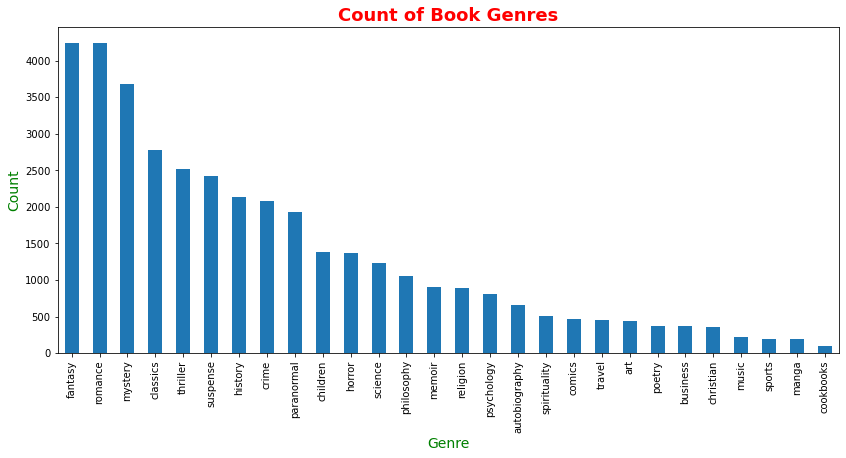

In [12]:
genre_join = tagged_book.merge(genres_id, on = "tag_id")
genre_count = genre_join.value_counts("genre")

fig, ax = plt.subplots(figsize = (14, 6))
genre_count.plot(kind = "bar").set_title("Count of Book Genres", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Genre", fontsize = 14, color = "g")
ax.set_ylabel("Count", fontsize = 14, color = "g")

plt.show()

**Distribution of ratings**

---

We checked to determine if any ratings may be missing in the ratings dataset and plotted the distribution

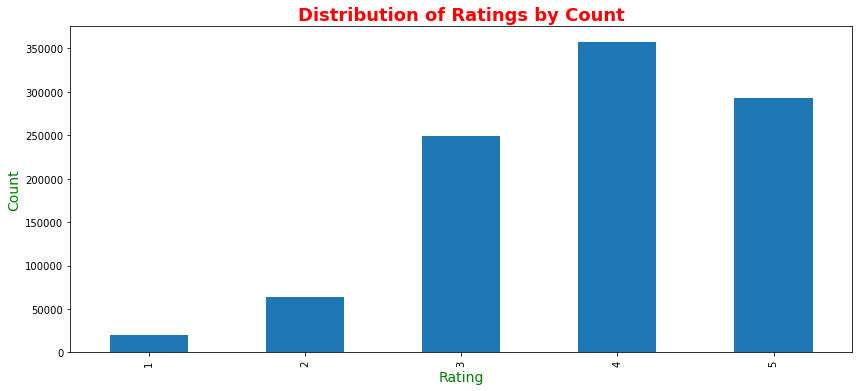

In [13]:
#Check to see if any rating is missing in the ratings dataset
ratings.isnull().sum()

#Plotted the distribution of ratings
fig, ax = plt.subplots(figsize = (14, 6))
ratings.value_counts("rating").sort_index().plot(kind = "bar").set_title("Distribution of Ratings by Count", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Rating", fontsize = 14, color = "g")
ax.set_ylabel("Count", fontsize = 14, color = "g")

plt.show()

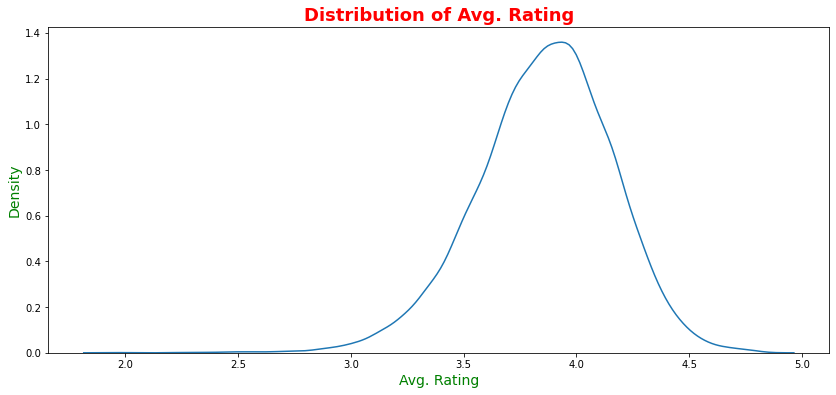

In [14]:
#Get the average rating per book_id
avg_rating_book = ratings.groupby("book_id").mean()

#Plotted the distribution of average rating per book
#We used Seaborn for this particular visualization
fig, ax = plt.subplots(figsize = (14, 6))
avg_rating_book = sns.kdeplot(avg_rating_book["rating"])

ax.set_title("Distribution of Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Avg. Rating", fontsize = 14, color = "g")
ax.set_ylabel("Density", fontsize = 14, color = "g")

plt.show()

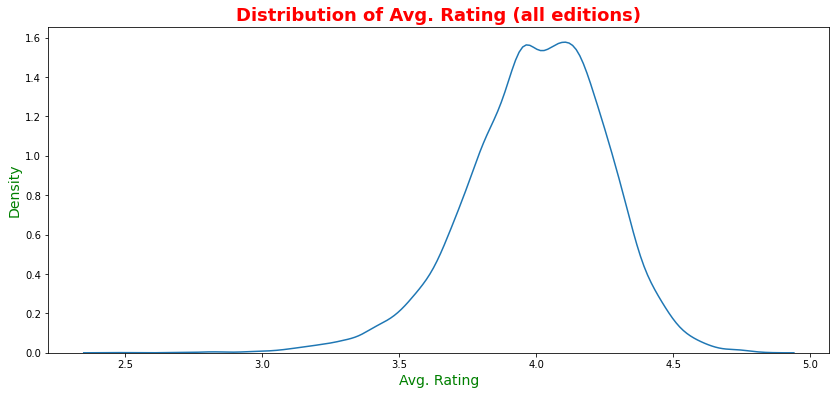

In [15]:
#Plotted the distribution of average rating per book (all editions of a particular book in Goodreads)
#We used Seaborn for this particular visualization
fig, ax = plt.subplots(figsize = (14, 6))
avg_rating_book_all_editions = sns.kdeplot(books_main["average_rating"])

ax.set_title("Distribution of Avg. Rating (all editions)", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Avg. Rating", fontsize = 14, color = "g")
ax.set_ylabel("Density", fontsize = 14, color = "g")

plt.show()

We got the average rating per "user_id" and plotted the distribution of the average rating per book

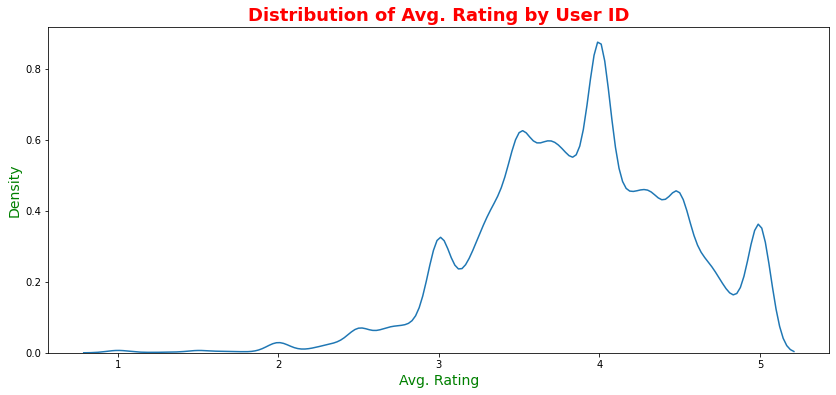

In [16]:
average_rating_user = ratings[["user_id", "rating"]].groupby("user_id").mean()
average_rating_user

#We used Seaborn for this particular visualization
fig, ax = plt.subplots(figsize = (14, 6))
average_rating_user = sns.kdeplot(average_rating_user["rating"])

ax.set_title("Distribution of Avg. Rating by User ID", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Avg. Rating", fontsize = 14, color = "g")
ax.set_ylabel("Density", fontsize = 14, color = "g")

plt.show()

Next, we grouped the total number of publications by authors that are associated with them

In [17]:
auth_books_count = books_main[["authors", "books_count"]].groupby("authors").sum()
auth_books_count.sort_values(by = "books_count", ascending = False)

#We can see that Shakespeare has the highest number of publications

,books_count
authors,
William Shakespeare,9284
Agatha Christie,8016
Stephen King,5894
Charles Dickens,5871
Arthur Conan Doyle,5409
...,...
"Andrew Williamson, Andrew Williamson",1
Steven Levy,1
"Dean Koontz, Leigh Nichols",1


We grouped the ratings by book_id and then took average rating per book_id

In [18]:
average_rate = ratings[["book_id", "rating"]].groupby("book_id").mean()
average_rate

,rating
book_id,
1,4.240000
2,4.210000
3,3.090000
4,4.460000
5,3.890000
...,...
9996,3.969388
9997,4.426966
9998,4.326316


**Exploring the language feature**

---


Currently, there are 25 language codes.

After removing 'mul', there are 24 language codes.

English             6335
American English    2065
British English      257
Arabic                63
Canadian English      58
French                25
Indonesian            21
Spanish               20
German                13
Persian                7
Japanese               7
Portugese              6
Polish                 6
Norwegian              3
Danish                 3
Finnish                2
Italian                2
Vietnamese             1
Turkish                1
Dutch                  1
Swedish                1
Romanian               1
Russian                1
Name: language_code, dtype: int64


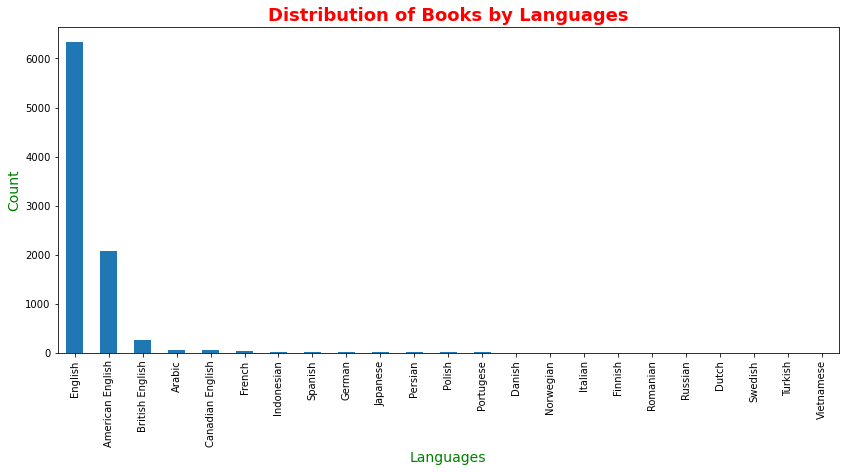

In [19]:
language = books_main["language_code"].dropna().nunique()
print("Currently, there are", language, "language codes.\n")

#mul is a multilingual value, others are singlular language, so we removed "mul"
books_main = books_main[books_main.language_code != "mul"]

language = books_main["language_code"].nunique()
print("After removing 'mul', there are", language, "language codes.\n")

#Replaced the abbreviations
mapping = [("ara", "Arabic"), ("fre", "French"), ("en", "English"), ("eng", "English"),
           ("en-US", "American English"), ("en-GB", "British English"), ("en-CA", "Canadian English"),
           ("ind", "Indonesian"), ("spa", "Spanish"), ("ger", "German"), ("per", "Persian"),
           ("jpn", "Japanese"), ("por", "Portugese"), ("pol", "Polish"),
           ("nor", "Norwegian"), ("dan", "Danish"), ("fil", "Finnish"),
           ("ita", "Italian"), ("vie", "Vietnamese"), ("tur", "Turkish"),
           ("nl", "Dutch"), ("swe", "Swedish"), ("rum", "Romanian"), ("rus", "Russian")]

#Plotted a new bar chart
for k, v in mapping:
    books_main.language_code = books_main.language_code.replace(k, v)
print(books_main.language_code.value_counts())

fig, ax = plt.subplots(figsize = (14, 6))
books_main.value_counts("language_code").plot(kind = "bar").set_title("Distribution of Books by Languages", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Languages", fontsize = 14, color = "g")
ax.set_ylabel("Count", fontsize = 14, color = "g")

plt.show()

#It seems the language column may not be as relevant to the rating - so do not consider this
#We believe that the website is American, so English is domninant in our available dataset, thus, this column is too biased
#Goodreads is an American social cataloging website and a subsidiary of Amazon that allows individuals to search its database of books, annotations, quotes, and reviews.
#There are some books are translated and made available in English or other languages
#Due to this, we cannot expect translations to be standardized (translation can impact negatively/positively)

To treat the missing values, we imputed the values

language_code
English             7104
American English    2310
British English      300
Arabic                75
Canadian English      62
French                25
Indonesian            24
Spanish               21
German                13
Japanese               8
Polish                 7
Persian                7
Portugese              6
Danish                 3
Norwegian              3
Italian                2
Finnish                2
Romanian               1
Russian                1
Dutch                  1
Swedish                1
Turkish                1
Vietnamese             1
dtype: int64


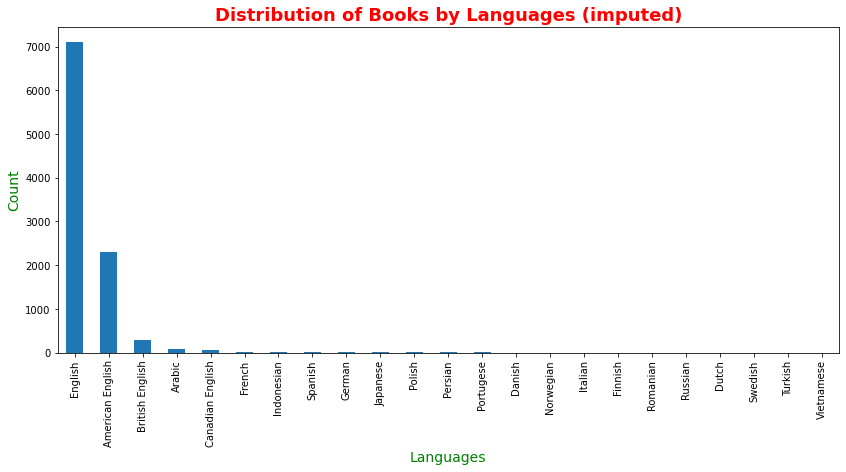

In [20]:
#Filled in the missing value in the "language_code" column by randomly selecting the value from the list of language code, probability by distribution of languages
s = books_main.language_code.value_counts(normalize = True)

d_imputation = books_main.copy()
missing = d_imputation["language_code"].isnull()
d_imputation.loc[missing,"language_code"] = np.random.choice(s.index, size = len(d_imputation[missing]), p = s.values)

#Check edif the imputation was done properly
print(d_imputation.value_counts("language_code"))

#Plotted the new distribution
fig, ax = plt.subplots(figsize = (14, 6))
d_imputation.value_counts("language_code").plot(kind = "bar").set_title("Distribution of Books by Languages (imputed)", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Languages", fontsize = 14, color = "g")
ax.set_ylabel("Count", fontsize = 14, color = "g")

plt.show()

Here, we created a dummy variable which checks if the book language is English or not which is then later used to check if there is any influence on the ratings

In [21]:
#Creating a dummy variable to label the language (isEnglish)
d_imputation["isEnglish"] = 0

for index, row in d_imputation.iterrows():
  if "En" in d_imputation["language_code"][index]:
    d_imputation["isEnglish"][index] = 1
  else:
    d_imputation["isEnglish"][index] = 0

d_imputation[["language_code", "isEnglish"]].head()

,language_code,isEnglish
0,English,1
1,English,1
2,American English,1
3,English,1
4,English,1


**Determine what factors (publication year, ratings count, language, number of books by the author etc.) have an influence on a book’s rating?**

---

We sorted "book_id", and merged it with the auth_books_count dataframe to include the total number of books by the specific author

Then we merged the average_rating dataframe to include the average_rating of each "book_id"

In [22]:
Sort = books_main[["book_id", "books_count", "authors", "language_code", "original_publication_year", "ratings_count", "work_text_reviews_count", "isbn_present", "isbn13_present"]].sort_values(by = "book_id")
Sort_merged = Sort.merge(auth_books_count, on = "authors")
Sort_merged.rename(columns = {"books_count_x":"#of_total_editions", "original_publication_year":"publication_yr", "ratings_count":"#of_ratings", "work_text_reviews_count":"#of_review_words", "books_count_y":"#of_total_books_by_author"}, inplace = True)
Sort_merged
complete = average_rate.merge(Sort_merged, on = "book_id")
complete.rename(columns = {"rating":"average_rating"}, inplace = True)
complete

#We can see that there are only 811 corresponding/matching book ids in ratings df and books_main df

,book_id,average_rating,#of_total_editions,authors,language_code,publication_yr,#of_ratings,#of_review_words,isbn_present,isbn13_present,#of_total_books_by_author
0,1,4.240000,275,"J.K. Rowling, Mary GrandPré",English,2005.0,1678823,27520,1,1,2094
1,2,4.210000,307,"J.K. Rowling, Mary GrandPré",English,2003.0,1735368,28685,1,1,2094
2,3,3.090000,491,"J.K. Rowling, Mary GrandPré",English,1997.0,4602479,75867,1,1,2094
3,5,3.890000,376,"J.K. Rowling, Mary GrandPré, Rufus Beck",English,1999.0,1832823,36099,1,1,376
4,6,4.090000,332,"J.K. Rowling, Mary GrandPré",English,2000.0,1753043,31084,1,1,2094
...,...,...,...,...,...,...,...,...,...,...,...
806,9914,3.936170,21,Bret Easton Ellis,British English,1994.0,12898,477,1,1,490
807,9915,3.677778,96,Bret Easton Ellis,English,1985.0,45978,2684,1,1,490
808,9943,4.460674,30,Francine Rivers,American English,1997.0,29250,1083,1,1,346
809,9957,3.336957,43,Ian McEwan,English,1978.0,14418,1343,1,1,874


We counted "book_id" in wishlists (also known as "to_read") with its ratings and plotted the distribution

We plotted the distribution with a scatterplot to evaluate the relationship between the number of books in the wishlist and ratings (color changes according to the density)

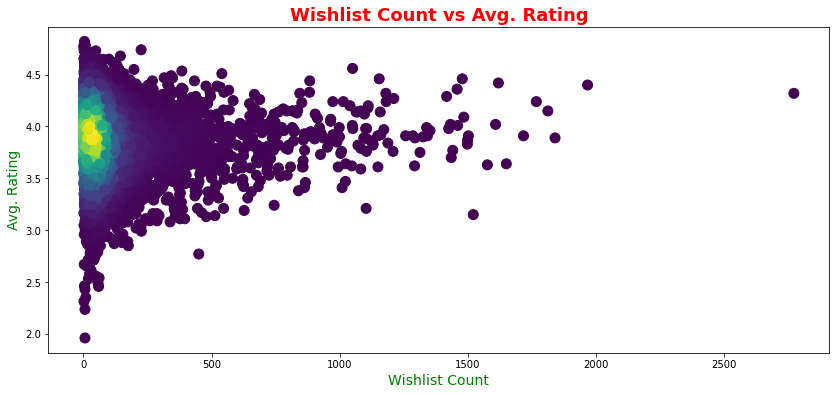

,wishlist_count,rating
book_id,,
9307,1,4.094340
6027,1,4.375000
9838,1,4.391892
9739,1,3.977273
8946,1,4.774194
...,...,...
11,1767,4.240000
13,1812,4.150000
113,1840,3.890000


In [23]:
book_wishlist = to_read.groupby("book_id").count()
book_wishlist.rename(columns = {"user_id": "wishlist_count"}, inplace = True)
book_ratings = ratings[["book_id", "rating"]].groupby("book_id").mean()
wishlistvratings = book_wishlist.merge(book_ratings, on = "book_id")

fig, ax = plt.subplots(figsize = (14, 6))
x = wishlistvratings["wishlist_count"]
y = wishlistvratings["rating"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.set_title("Wishlist Count vs Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Wishlist Count", fontsize = 14, color = "g")
ax.set_ylabel("Avg. Rating", fontsize = 14, color = "g")
ax.scatter(x, y, c = z, s = 100)

plt.show()

wishlistvratings.sort_values("wishlist_count", ascending = True)

#Based on this, the group believes that we cannot draw any significant relationship between a book's wishlist count and its rating

We plotted the distribution with a scatterplot to evaluate the relationship between the number of books by author and ratings (color changes according to the density)

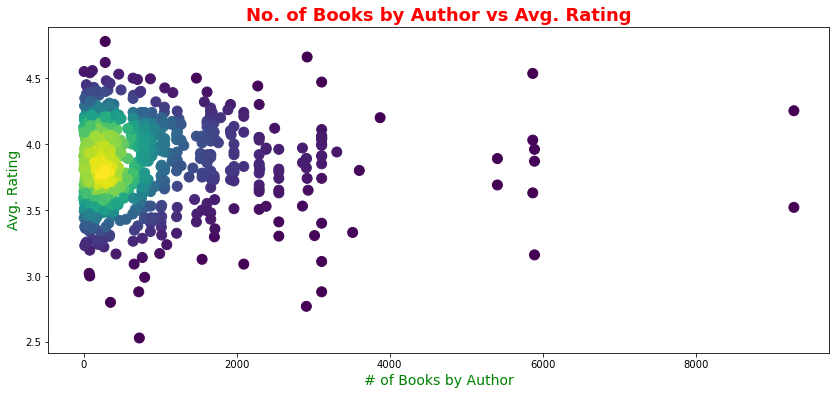

In [24]:
fig, ax = plt.subplots(figsize = (14, 6))
a = complete["#of_total_books_by_author"]
b = complete["average_rating"]
ab = np.vstack([a,b])
t = gaussian_kde(ab)(ab)

ax.set_title("No. of Books by Author vs Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("# of Books by Author", fontsize = 14, color = "g")
ax.set_ylabel("Avg. Rating", fontsize = 14, color = "g")
ax.scatter(a, b, c = t, s = 100)

plt.show()

We plotted average_ratings where "isbn13" is present and where "isbn13" is absent

1    802
0      9
Name: isbn_present, dtype: int64


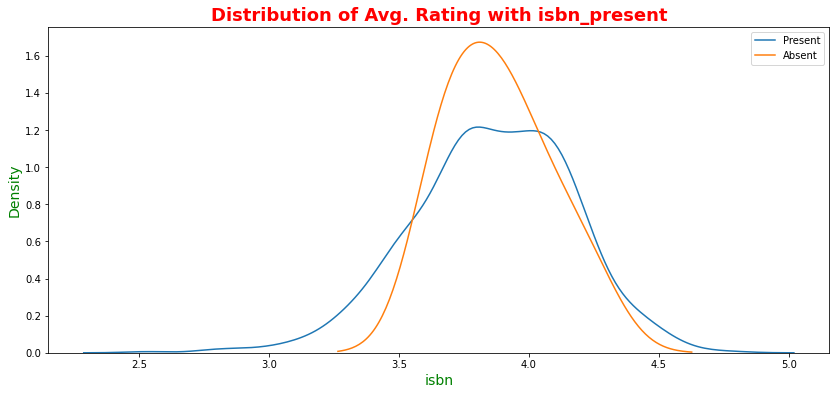

1    807
0      4
Name: isbn13_present, dtype: int64


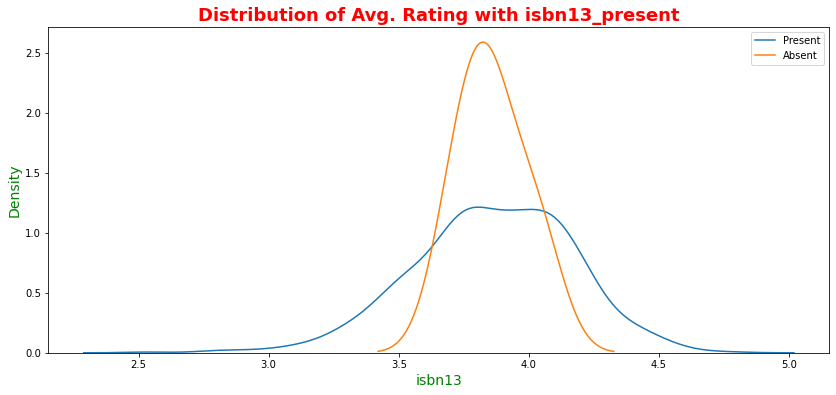

In [25]:
for isbn in ["isbn", "isbn13"]:
  #We used Seaborn for this particular visualization
  fig, ax = plt.subplots(figsize = (14, 6))
  sns.distplot(x = complete[complete[f"{isbn}_present"] == 1]["average_rating"], hist = False, rug = False)
  sns.distplot(x = complete[complete[f"{isbn}_present"] == 0]["average_rating"], hist = False, rug = False)
  ax.set_title(f"Distribution of Avg. Rating with {isbn}_present", fontsize = 18, weight = "bold", color = "r")
  ax.set_xlabel(isbn, fontsize = 14, color = "g")
  ax.set_ylabel("Density", fontsize = 14, color = "g")
  plt.legend(labels = ["Present", "Absent"])

  print(complete[f"{isbn}_present"].value_counts())
  plt.show()

#As a result, we cannot conclude that there is a significant influence of isbn on the avg. ratings

We plotted the "publication_year" with ratings using a scatterplot (color changes according to the density)

     book_id  publication_yr    rating
768     9566          1980.0  4.777778
353     4708          1922.0  4.660000
770     9569          2003.0  4.618557
761     9531          2006.0  4.557143
290     3885          2006.0  4.550000
..       ...             ...       ...
457     5355          1994.0  2.880000
505     5890          1859.0  2.880000
677     7980          1996.0  2.800000
18        34          1954.0  2.770000
303     4009          1953.0  2.530000

[811 rows x 3 columns]


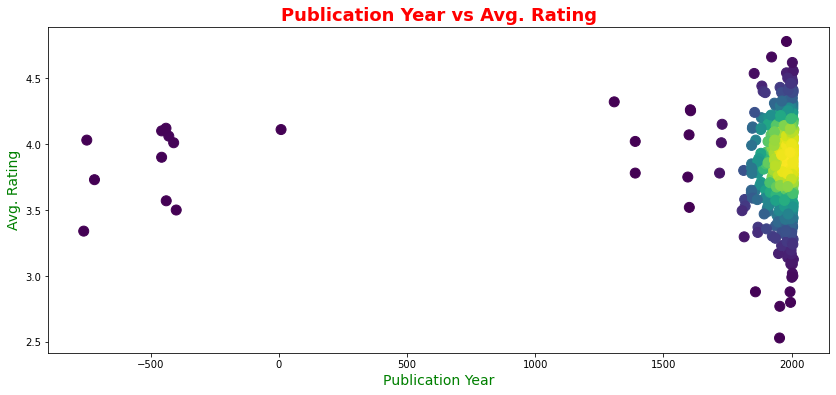

In [26]:
book_ratings = ratings[["book_id", "rating"]].groupby("book_id").mean()

pubyearvratings = complete[["book_id", "publication_yr"]].merge(book_ratings, on = "book_id")
print(pubyearvratings.sort_values(["rating"], ascending = False))

fig, ax = plt.subplots(figsize = (14, 6))
x = pubyearvratings["publication_yr"]
y = pubyearvratings["rating"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.set_title("Publication Year vs Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Publication Year", fontsize = 14, color = "g")
ax.set_ylabel("Avg. Rating", fontsize = 14, color = "g")
ax.scatter(x, y, c = z, s = 100)

plt.show()

#We notice some extreme values in publication_year less than 0,
#The reason for the negative years seems to be due to some really old books i.e. from 2000 BC
#The negative values are not absolute values of the BC year, and we could not identify any real meaning for these negative year values
#Therefore, the team has decided to ignore them in the analysis

#Additionally, just by reviewing the graph, we cannot not find any strong influence on the rating by publication_year

We plotted the average rating by the number of ratings (in millions) (color changes according to the density)

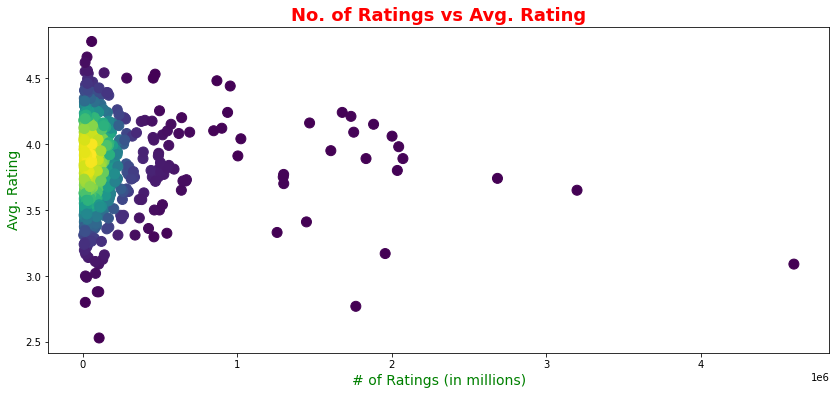

,book_id,#of_ratings,rating
768,9566,56802,4.777778
353,4708,26597,4.660000
770,9569,14206,4.618557
761,9531,29555,4.557143
290,3885,14469,4.550000
...,...,...,...
457,5355,102715,2.880000
505,5890,93134,2.880000
677,7980,15605,2.800000
18,34,1766803,2.770000


In [27]:
rcountvratings = complete[["book_id", "#of_ratings"]].merge(book_ratings, on = "book_id")

fig, ax = plt.subplots(figsize = (14, 6))
x = rcountvratings["#of_ratings"]
y = rcountvratings["rating"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.set_title("No. of Ratings vs Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("# of Ratings (in millions)", fontsize = 14, color = "g")
ax.set_ylabel("Avg. Rating", fontsize = 14, color = "g")
ax.scatter(x, y, c = z, s = 100)

plt.show()

rcountvratings.sort_values(["rating"], ascending = False)

#Again, there is no significant relationship between these two

**Is there any difference between the average rating of the users who rate more frequently than those who don’t?**

---

We merged the ratings and plotted the distribution by the number of reviews and ratings (color changes according to the density)

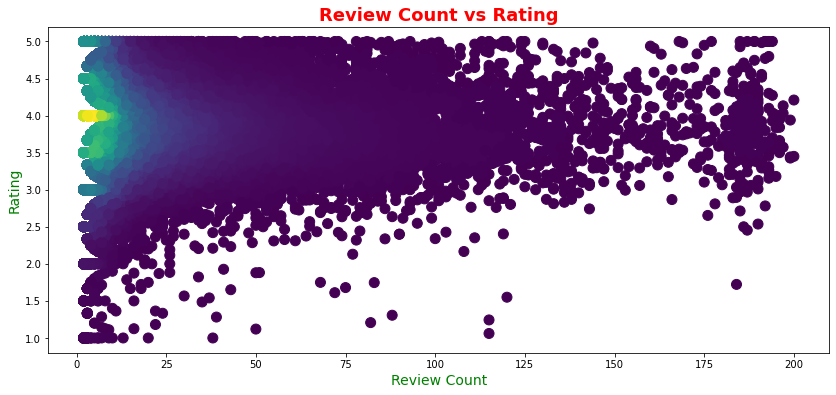

In [28]:
base = ratings[["user_id", "book_id"]].groupby(by = "user_id").count()
base.rename(columns = {"book_id":"review_count"}, inplace = True)
add = ratings[["user_id", "rating"]].groupby(by = "user_id").mean()
per_user = base.merge(add, on = "user_id")

fig, ax = plt.subplots(figsize = (14, 6))
x = per_user["review_count"]
y = per_user["rating"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.set_title("Review Count vs Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Review Count", fontsize = 14, color = "g")
ax.set_ylabel("Rating", fontsize = 14, color = "g")
ax.scatter(x, y, c = z, s = 100)

plt.show()

#Users that have lower count of reviews tend to have variations in ratings
#As the number of reviews increases, so does the tendency of ratings higher increases
#However, users tend to give higher ratings if they only review few books as well

**Does the number of volumes affect the rating?**

---

We grouped the volumized titles as well as grouped the single book titles and took the average of average rating to compare with rating

The difference between average rating of volumized books VS single book titles is
4.06834601173658 VS 3.944924679189144


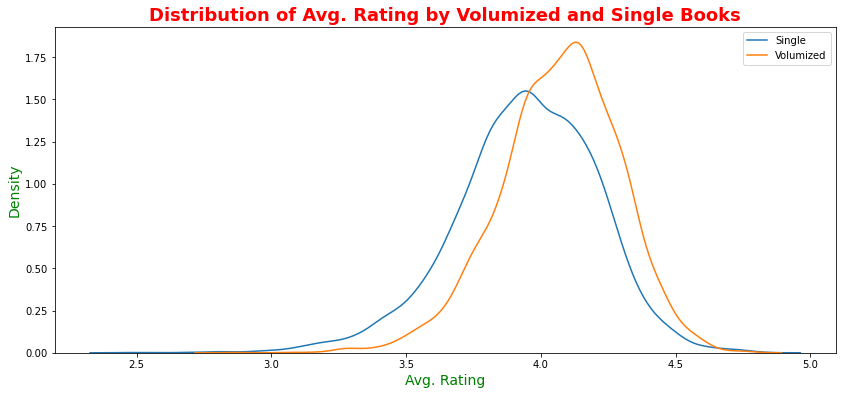

In [29]:
books_main2 = books_main.copy()
volumized = books_main2[books_main2.title.str.contains('vol|#', case = False, regex = True)]
single = books_main2[books_main2.title.str.contains('vol|#', case = False, regex = True) == False]

print('The difference between average rating of volumized books VS single book titles is')
print(volumized['average_rating'].mean(),'VS', single['average_rating'].mean())

#Plotted the distribution of average rating for single book titles
fig, ax = plt.subplots(figsize = (14, 6))
ax.set_title("Distribution of Avg. Rating by Volumized and Single Books", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Avg. Rating", fontsize = 14, color = "g")
ax.set_ylabel("Density", fontsize = 14, color = "g")

sns.kdeplot(single['average_rating'])
sns.kdeplot(volumized['average_rating'])
plt.legend(labels = ["Single", "Volumized"])

plt.show()

We created a volume number of volumized books into a column, took the average rating of each volume group and plotted a scatter diagram

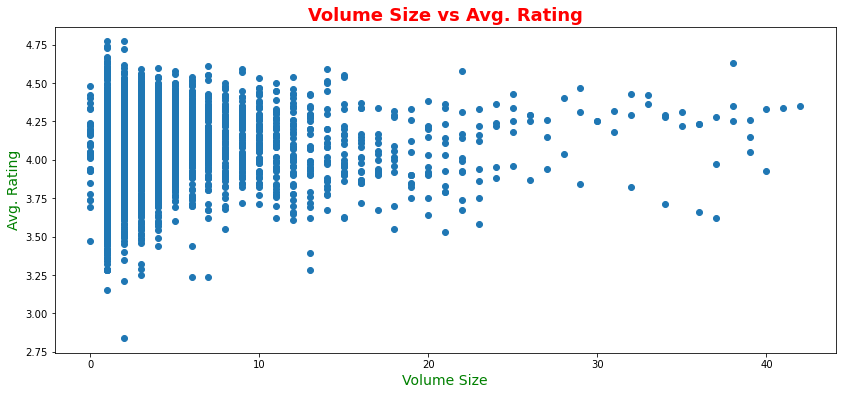

In [30]:
volumized['vol_count'] = volumized.title.str.extract(r'vol |#(\d+)', expand = True).astype(float)
volumized[['average_rating', 'vol_count']].groupby('vol_count').mean()

fig, ax = plt.subplots(figsize = (14, 6))

ax.set_title("Volume Size vs Avg. Rating", fontsize = 18, weight = "bold", color = "r")
ax.set_xlabel("Volume Size", fontsize = 14, color = "g")
ax.set_ylabel("Avg. Rating", fontsize = 14, color = "g")
ax.scatter(volumized['vol_count'], volumized['average_rating'])

plt.show()

There seems to be some sort of pattern where books with bigger volumes tend to have higher ratings.
However, it doesn't seem to be a significant impact on the ratings, so in other words, single books and volumized books have similar ratings,
and with a bigger sample size (more than 10k rows), we may be able to test this theory again